In [1]:
import cv2
import os
import numpy as np 
import pandas as pd 
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from ultralyticsplus import YOLO, render_result 
# pip install ultralyticsplus==0.0.21

/opt/conda/envs/dclc3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Testing an open source segmentation model

We first start with loading an open source model for building segmentation problem and use that to rank the masks. For this experiment, we are looking into https://yolov8.xyz/#/?id=about-the-project repo, look for "building-segmentation" to find the relevant model. Let's load it up


In [2]:
def plot_image_with_mask(img, mask, alpha=0.4):
    """
    Plots the image with an overlay of the mask in red, resizing the mask to match the image.

    Args:
    - img (str or numpy array): Path to the image file or image array.
    - mask (str or numpy array): Path to the mask file or mask array.
    - alpha (float): Transparency for overlaying mask.
    """

    # If img is a path, read the image file
    if isinstance(img, str):
        img = cv2.imread(img)

    # If mask is a path, read the mask file
    if isinstance(mask, str):
        mask = cv2.imread(mask)

    # Convert image from BGR to RGB for displaying with matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize the mask to match the image size
    mask_resized = cv2.resize(mask, (img_rgb.shape[1], img_rgb.shape[0]))

    # Combine all three channels of the mask by taking the max value across channels
    mask = np.clip(np.max(mask_resized, axis=2), 0, 1)

    # Create a colored mask (Red where the mask is 1, transparent elsewhere)
    colored_mask = np.zeros_like(img_rgb)  # Same shape as img, but all zeros
    colored_mask[:, :, 0] = mask * 255  # Red channel gets the mask values

    # Overlay the red mask on the original image using alpha blending
    overlay_img = cv2.addWeighted(img_rgb, 1 - alpha, colored_mask, alpha, 0)

    # Plot the image with the red mask overlay
    plt.figure(figsize=(6, 6))
    plt.imshow(overlay_img)
    plt.title("Image with Red Mask Overlay")
    plt.axis('off')
    plt.show()

In [3]:
# Creates a list of all the images and masks in the folder
masks = glob("/home/contact_mine_ai/DCLC3/data/dataset/training_noisy_labels/*png")
images = glob("/home/contact_mine_ai/DCLC3/data/dataset/training_patches/*png")

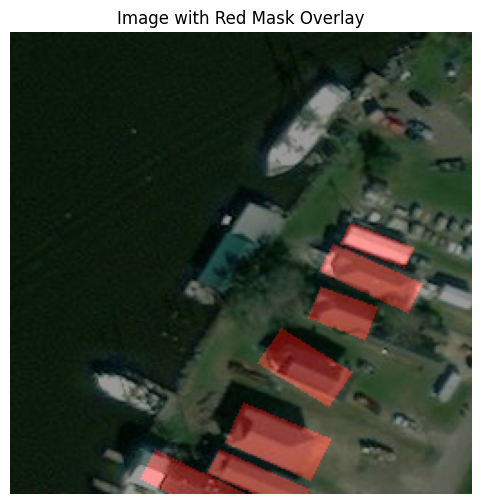

In [4]:
idx = 80
plot_image_with_mask(images[idx], masks[idx])

Task #1: Understand the different models and hyperparameters for the model. Tune the model to get the best (doesn't have to be perfect) results. Look at multiple images for this experiment.


In [16]:
# load model
model = YOLO('keremberke/yolov8m-building-segmentation')

# set model parameters
model.overrides['conf'] = 0.25  # NMS confidence threshold
model.overrides['iou'] = 0.45  # NMS IoU threshold
model.overrides['agnostic_nms'] = False  # NMS class-agnostic
model.overrides['max_det'] = 1000  # maximum number of detections per image

/opt/conda/envs/dclc3/lib/python3.10/site-packages/ultralytics/nn/tasks.py:332: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_location='cpu')  # 

In [17]:
# perform inference
results = model.predict(images[idx])
pred_mask = results[0].masks.masks.cpu().permute(1,2,0).numpy()

Ultralytics YOLOv8.0.20 🚀 Python-3.10.15 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 14918MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


In [18]:
# note: prediction mask shape is differnt from the input image. Side quest: figure out why?
pred_mask.shape

(640, 640, 13)

In [19]:
# let's see what the predictions are made of
np.unique(pred_mask)

array([          0,           1], dtype=float32)

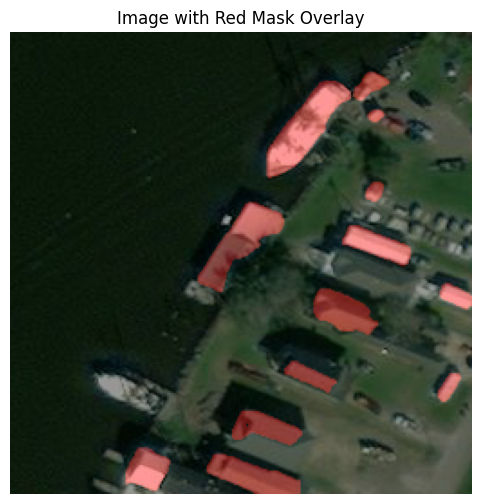

In [20]:
# plot the predicted mask
plot_image_with_mask(images[idx], pred_mask)

## Run Inference using the open source model

Task #2 :  Once the model is tuned, run infernce on all the images to get the masks. We will use these masks for ranking the images later on. 

In [55]:
masks = glob("/home/contact_mine_ai/DCLC3/data/dataset/training_noisy_labels/*png")
images = glob("/home/contact_mine_ai/DCLC3/data/dataset/training_patches/*png")

In [56]:
# load model
model = YOLO('keremberke/yolov8m-building-segmentation')

# set the tuned model parameters
model.overrides['conf'] = 0.01  # NMS confidence threshold
model.overrides['iou'] = 0.45  # NMS IoU threshold
model.overrides['agnostic_nms'] = False  # NMS class-agnostic
model.overrides['max_det'] = 100000  # maximum number of detections per image

/opt/conda/envs/dclc3/lib/python3.10/site-packages/ultralytics/nn/tasks.py:332: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_location='cpu')  # 

In [58]:
for img_path, msk_path in tqdm(zip(images[80:], masks[80:]), total=len(images)):
    # Perform inference
    results = model.predict(img_path)
    
    # Check if masks exist in the result
    if results[0].masks is not None and len(results[0].masks.masks) > 0:
        # Get the predicted mask (assuming you're working with the first result)
        pred_mask = np.max(results[0].masks.masks.cpu().permute(1, 2, 0).numpy(), axis=2)
        pred_mask = np.stack([pred_mask] * 3, axis=-1)  # Stack to make it 3 channels (RGB)
    else:
        # If no mask is predicted, create an empty (black) mask of the same shape as the input image
        img = cv2.imread(img_path)  # Read the image to get its dimensions
        pred_mask = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)  # Create black mask (3-channel)

    # Resize the predicted mask (or empty mask) to 256x256
    pred_mask_resized = cv2.resize(pred_mask, (256, 256))

    # Create the corresponding output path by replacing 'training_patches' with 'pred_masks'
    output_path = img_path.replace('training_patches', 'pred_masks')

    # Ensure the output directory exists (for nested directories)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    # Save the resized mask to the output directory
    cv2.imwrite(output_path, pred_mask_resized)
    
    break  # Assuming this is for debugging, you can remove it for the full loop

  0%|          | 0/5000 [00:00<?, ?it/s]


tensor([[1.84000e+02, 1.07000e+02, 2.22000e+02, 1.29000e+02, 7.52633e-01, 0.00000e+00],
        [6.30000e+01, 2.30000e+02, 8.90000e+01, 2.55000e+02, 6.96172e-01, 0.00000e+00],
        [1.42000e+02, 2.60000e+01, 1.90000e+02, 8.00000e+01, 5.89413e-01, 0.00000e+00],
        [1.22000e+02, 2.08000e+02, 1.62000e+02, 2.29000e+02, 5.68502e-01, 0.00000e+00],
        [1.03000e+02, 9.30000e+01, 1.53000e+02, 1.46000e+02, 4.97747e-01, 0.00000e+00],
        [1.08000e+02, 2.32000e+02, 1.60000e+02, 2.56000e+02, 4.80762e-01, 0.00000e+00],
        [1.52000e+02, 1.82000e+02, 1.82000e+02, 2.01000e+02, 4.19619e-01, 0.00000e+00],
        [1.68000e+02, 1.41000e+02, 2.04000e+02, 1.68000e+02, 3.12595e-01, 0.00000e+00],
        [2.36000e+02, 1.87000e+02, 2.50000e+02, 2.06000e+02, 2.96651e-01, 0.00000e+00],
        [2.38000e+02, 1.39000e+02, 2.56000e+02, 1.54000e+02, 2.93109e-01, 0.00000e+00],
        [1.98000e+02, 4.20000e+01, 2.08000e+02, 5.10000e+01, 2.71614e-01, 0.00000e+00],
        [1.89000e+02, 2.10000e+0

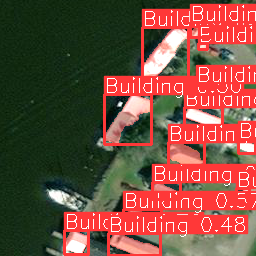

In [59]:
# observe results
print(results[0].boxes)
print(results[0].masks)
render = render_result(model=model, image=img_path, result=results[0])
render

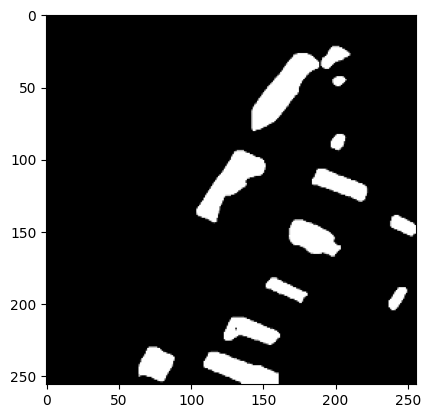

In [60]:
# plot the predicted mask
plt.imshow(pred_mask_resized)

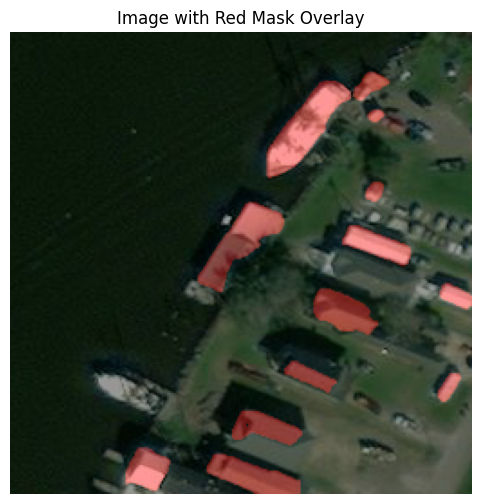

In [61]:
# plot the predicted mask with image
plot_image_with_mask(img_path, pred_mask_resized)

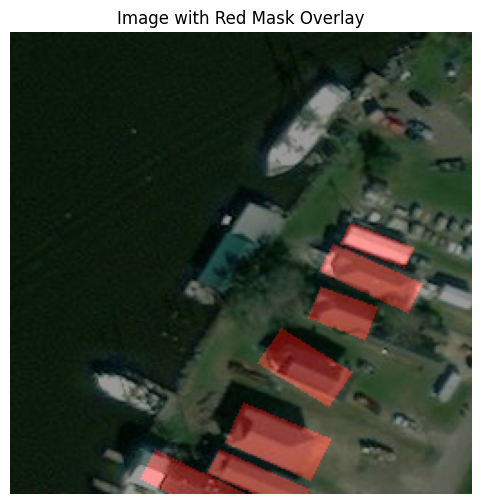

In [62]:
# plot the mask from dataset
plot_image_with_mask(img_path, msk_path)

## Run Eval and Rank the images

Task #3 : Using the predicted masks and actual masks, write a function to calculate the IoU metric between them to rank the images.

In [22]:

%cd /Users/harshitmathur/Downloads


/Users/harshitmathur/Downloads


In [19]:
import torch
from torch.utils.data import Dataset
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms


In [23]:
class myDataset(Dataset):
    def __init__(self, csvfile_dir, transform=False):
        self.data = pd.read_csv(csvfile_dir)
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        imageid = self.data.iloc[idx, 0]
        image_path = f"dataset/training_patches/{imageid}"
        mask_path = image_path.replace("training_patches", "training_noisy_labels")

        # Load image and mask
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path)
        # Convert image and mask to RGB (if needed)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Convert mask to single channel if needed (e.g., take the first channel)
        mask = mask[:, :, 0]  # Take one channel, assuming all are the same

        if self.transform:
            t = transforms.Compose([transforms.ToTensor()])
            image = t(image)
            mask = t(mask).unsqueeze(0)  # Ensure mask is 1 channel
        else:
            # Convert to PyTorch tensors manually if no transform
            image = torch.as_tensor(image, dtype=torch.float32).permute(2, 0, 1)  # Normalize
            mask = torch.as_tensor(mask, dtype=torch.float32).unsqueeze(0)  # Single channel mask

        return image, mask

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class UNetMobileNetV2(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(UNetMobileNetV2, self).__init__()

        # Load the pretrained MobileNetV2 as the encoder
        mobilenet_v2 = models.mobilenet_v2(pretrained=pretrained)

        # Extract feature layers from the MobileNetV2 encoder
        self.encoder = mobilenet_v2.features

        # Upsampling / Decoder part
        self.upconv1 = nn.ConvTranspose2d(1280, 320, kernel_size=2, stride=2)
        self.decoder1 = self.conv_block(320 + 96, 320)

        self.upconv2 = nn.ConvTranspose2d(320, 192, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(192 + 32, 192)

        self.upconv3 = nn.ConvTranspose2d(192, 64, kernel_size=2, stride=2)
        self.decoder3 = self.conv_block(64 + 24, 64)

        self.upconv4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.decoder4 = self.conv_block(32 + 16, 32)

        self.upconv5 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.decoder5 = self.conv_block(16 + 3, 16)  # Adding skip connection with input

        # Final 1x1 convolution to get the desired number of output channels
        self.final_conv = nn.Conv2d(16, num_classes, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder: Forward through MobileNetV2
        enc1 = self.encoder[0:2](x)    # [3, 256, 256] -> [16, 128, 128]
        enc2 = self.encoder[2:4](enc1) # [16, 128, 128] -> [24, 64, 64]
        enc3 = self.encoder[4:7](enc2) # [24, 64, 64] -> [32, 32, 32]
        enc4 = self.encoder[7:14](enc3) # [32, 32, 32] -> [96, 16, 16]
        enc5 = self.encoder[14:](enc4) # [96, 16, 16] -> [1280, 8, 8]

        # Decoder: Upsample and concatenate with corresponding encoder layers
        dec1 = self.upconv1(enc5)          # [1280, 8, 8] -> [320, 16, 16]
        dec1 = torch.cat([dec1, enc4], dim=1)  # Concatenate with enc4
        dec1 = self.decoder1(dec1)         # [320 + 96, 16, 16] -> [320, 16, 16]

        dec2 = self.upconv2(dec1)          # [320, 16, 16] -> [192, 32, 32]
        dec2 = torch.cat([dec2, enc3], dim=1)  # Concatenate with enc3
        dec2 = self.decoder2(dec2)         # [192 + 32, 32, 32] -> [192, 32, 32]

        dec3 = self.upconv3(dec2)          # [192, 32, 32] -> [64, 64, 64]
        dec3 = torch.cat([dec3, enc2], dim=1)  # Concatenate with enc2
        dec3 = self.decoder3(dec3)         # [64 + 24, 64, 64] -> [64, 64, 64]

        dec4 = self.upconv4(dec3)          # [64, 64, 64] -> [32, 128, 128]
        dec4 = torch.cat([dec4, enc1], dim=1)  # Concatenate with enc1
        dec4 = self.decoder4(dec4)         # [32 + 16, 128, 128] -> [32, 128, 128]

        dec5 = self.upconv5(dec4)          # [32, 128, 128] -> [16, 256, 256]
        dec5 = torch.cat([dec5, x], dim=1)     # Concatenate with input image
        dec5 = self.decoder5(dec5)         # [16 + 3, 256, 256] -> [16, 256, 256]

        # Final output
        out = self.final_conv(dec5)        # [16, 256, 256] -> [1, 256, 256] (binary output)
        return out

In [36]:
from torch.utils.data import DataLoader

# Assuming your myDataset function is implemented and gives [3, 256, 256] and [1, 256, 256]
train_dataset = myDataset('first 20.csv')
# val_dataset = myDataset('path_to_val_images', 'path_to_val_masks')

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [40]:
import torch.optim as optim

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, loss function, and optimizer
model = UNetMobileNetV2(num_classes=1, pretrained=True).to(device)
criterion = nn.BCEWithLogitsLoss()  # For binary segmentation
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [42]:
# Training function
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, masks in dataloader:
        images = images.to(device)          # [batch_size, 3, 256, 256]
        masks = masks.to(device)            # [batch_size, 1, 256, 256]

        optimizer.zero_grad()
        outputs = model(images)             # [batch_size, 1, 256, 256]
        loss = criterion(outputs, masks)    # Compute loss

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    return running_loss / len(dataloader)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    # val_loss = validate(model, val_loader, criterion, device)

    print( f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}")

Epoch 1/100, Train Loss: 0.1435280442237854
Epoch 2/100, Train Loss: 0.14075846473375955
Epoch 3/100, Train Loss: 0.1375534882148107
Epoch 4/100, Train Loss: 0.13486781219641367
Epoch 5/100, Train Loss: 0.1325525219241778
Epoch 6/100, Train Loss: 0.12994767228762308
Epoch 7/100, Train Loss: 0.12717144439617792
Epoch 8/100, Train Loss: 0.12458175917466481
Epoch 9/100, Train Loss: 0.12239487220843633
Epoch 10/100, Train Loss: 0.11976756155490875
Epoch 11/100, Train Loss: 0.11744430661201477
Epoch 12/100, Train Loss: 0.11506957312424977
Epoch 13/100, Train Loss: 0.11289727687835693
Epoch 14/100, Train Loss: 0.11068383852640788
Epoch 15/100, Train Loss: 0.10873681803544362
Epoch 16/100, Train Loss: 0.10670721779266994
Epoch 17/100, Train Loss: 0.10463303575913112
Epoch 18/100, Train Loss: 0.10258845488230388
Epoch 19/100, Train Loss: 0.10073613127072652
Epoch 20/100, Train Loss: 0.09942853947480519
Epoch 21/100, Train Loss: 0.09804925570885341
Epoch 22/100, Train Loss: 0.09646122654279073
